In [35]:
# load the human-judgements file
import os, json

# Path to the uploaded file
results_dir = '../competition/NIST_data/'

file_paths = [
    # 'final.citation_judgments_with_prediction.20241025.jsonl',
    'final.citation_judgments_Webassess.20241031.jsonl',
    'final.citation_judgments_without_prediction.20241025.jsonl'
]

# Initialize an empty list to store each row's JSON data
human_citation_data = {}

# Open the file and read line by line
for filepath in file_paths:
    file_path = os.path.join(results_dir, filepath)
    with open(file_path, 'r') as file:
        for idx, line in enumerate(file):
            json_data = json.loads(line)
            run_id = json_data['run_id']
            topic_id = json_data['topic_id']

            if topic_id not in human_citation_data:
                human_citation_data[topic_id] = {run_id: json_data}
            else:
                human_citation_data[topic_id][run_id] = json_data

In [36]:
print('Number of topics:', len(human_citation_data))

Number of topics: 22


In [37]:
RUNFILES = {
    "auggen": set([
        "ldisnu.ldilab_gpt_4o",
        "IIIA-UNIPD.iiia_dedup_p1_straight_ag",
        "IIIA-UNIPD.iiia_standard_p1_straight_ag",
        "softbank-meisei.agtask-bm25-colbert_faiss-gpt4o-llama70b",
        "CIR.cir_gpt-4o-mini_Cosine_50_0.5_100_301_p1",
        "CIR.cir_gpt-4o-mini_no_reranking_50_0.5_100_301_p1",
        "KML.gpt_mini",
        "KML.cohere+post_processing",
        "uis-iai.ginger_top_5",
        "uis-iai.baseline_top_5",
        "TREMA-UNH.Enhanced_Iterative_Fact_Refinement_and_Prioritization",
        "TREMA-UNH.Ranked_Iterative_Fact_Extraction_and_Refinement",
        "IITD-IRL.ag_rag_gpt35_expansion_rrf_20",
        "coordinators.baseline_rag24.test_l31_70b_instruct_top20",
    ]),
    "gen": set([
        "ldisnu.dilab_repllama_listt5_pass3_gpt4o",
        "WaterlooClarke.UWCgarag",
        "WaterlooClarke.UWCrag",
        "buw.oneshot_post_sentenced",
        "buw.buw",
        "citi.BEST_cot_gpt3.5",
        "citi.SECOND_cot_gpt3.5",
        "ielab.ielab-b70bf-70bqp-70bafs",
        "ielab.ielab-b70bf-70bqfs-ad_hoc",
        "ii_research.iiresearch-bm25-top10-llama3-8b-instruct",
        "InfoLab.UDInfolab.RAG.Query",
        "InfoLab.UDInfolab.RAG.AnsAI",
        "IRIT.ISIR-IRIT-zephyr_p2",
        "IRIT.ISIR-IRIT-zephyr_query_gen",
        "ncsu-las.LAS-splade-mxbai-rrf-mmr8",
        "ncsu-las.LAS-splade-mxbai-mmr8-RAG",
        "neu.neurag",
        "neu.neuragfix",
        "Ruc01.ruc001",
        "SGU.qrant_bge_gemini",
        "softbank-meisei.rag_bm25-colbert_faiss-gpt4o-llama70b",
        "webis.webis-manual",
        "webis.webis-rag-run0-taskrag",
        "webis.webis-rag-run1-taskrag",
        "IITD-IRL.zeph_test_rag_rrf_expand_query",
        "uog-tht.FT-llama3",
        "uog-tht.ICL-mistral",
        "coordinators.baseline_frag_rag24.test_gpt-4o_top20",
        "coordinators.baseline_frag_rag24.test_command-r-plus_top20",
        "h2oloo.listgalore_gpt4o_ragnarokv4_top20",
        "h2oloo.listgalore_l31-70b_ragnarokv4_top20",
    ])
}

In [38]:
# Load synthetic judgements by LLM
llm_results_directory = "/store/scratch/n3thakur/trec-rag-2024/trec2024-rag/support_eval/results/support/"

llm_citation_data = {}

for task in ["auggen", "gen"]:
    runfiles = RUNFILES[task]

    for runfile in runfiles:
        with open(os.path.join(llm_results_directory, task, "pairwise", f"{runfile}.jsonl"), "r") as file:
            for idx, line in enumerate(file):
                json_data = json.loads(line)
                json_data['sentences'] = json_data['support_eval']
                del json_data['support_eval']
                
                topic_id = json_data['topic_id']
                if topic_id in human_citation_data:
                    if topic_id not in llm_citation_data:
                        llm_citation_data[topic_id] = {runfile: {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}}
                    else:
                        llm_citation_data[topic_id][runfile] = {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}


In [39]:
print('Number of topics:', len(llm_citation_data))

Number of topics: 22


In [8]:
# Get the lucene searcher for document text and id
from pyserini.search import LuceneSearcher

lucene_index = "/store/scratch/rpradeep/nuggetizer/data/indexes/lucene-inverted.msmarco-v2.1-doc-segmented"
seg_index = LuceneSearcher(lucene_index)


/home/n3thakur/anaconda3/envs/unsloth_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Nov 20, 2024 7:14:39 P.M. org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


In [40]:
# Compare the confusion matrix of the human judgements and the LLM judgements
# disagreement between human and LLM judgements

from sklearn.metrics import confusion_matrix
import random

random.seed(42)

LLM_JUDGEMENT_DICT = {
    "FS": 2,
    "PS": 1,
    "NS": 0
}

final_sampled_data = []
count = 0

for topic_id in human_citation_data:
    
    print(topic_id)
    per_topic_sampled_data = []
    
    for run_id in human_citation_data[topic_id]:
        human_pred = human_citation_data[topic_id][run_id]
        llm_pred = llm_citation_data[topic_id][run_id]

        # check if both sentences lengths are equal
        assert len(llm_pred["sentences"]) == len(human_pred["sentences"])
        references = llm_pred["references"]

        # go through each sentence one by one
        for human_sentence, llm_sentence in zip(human_pred["sentences"], llm_pred["sentences"]):

            try:
                if len(human_sentence['citations']) > 0:
                    if "citationId" in human_sentence['citations'][0]:
                        human_reference = human_sentence['citations'][0]['citationId']
                    else:
                        human_reference = human_sentence['citations'][0]['citationID']
                    
                    human_doc_id = human_sentence['citations'][0]['reference']

                    index = llm_sentence['citations'].index(human_reference)
                    llm_doc_id = references[llm_sentence['citations'][index]]

                    assert human_doc_id == llm_doc_id

                    human_judgement = int(human_sentence['citations'][0]['support'])
                    llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][index]]

                    if human_judgement != -1:
                        if human_judgement != llm_judgement:
                            seg = json.loads(seg_index.doc(human_doc_id).raw())
                            doc_text = seg['title'] + ': ' + seg['segment']
                            per_topic_sampled_data.append({
                                "topic_id": topic_id, 
                                "run_id": run_id, 
                                "doc_id": human_doc_id,
                                "sentence": human_sentence['text'],
                                "doc_text": doc_text,
                                "human_judgement": human_judgement, 
                                "llm_judgement": llm_judgement}
                            )

            except:
                if len(human_sentence['citations']) > 0:
                    
                    human_doc_id = human_sentence['citations'][0]['reference']
                    llm_doc_id = references[llm_sentence['citations'][0]]

                    assert human_doc_id == llm_doc_id

                    human_judgement = int(human_sentence['citations'][0]['support'])
                    llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][0]]

                    if human_judgement != -1:
                        if human_judgement != llm_judgement:
                            seg = json.loads(seg_index.doc(human_doc_id).raw())
                            doc_text = seg['title'] + ': ' + seg['segment']
                            per_topic_sampled_data.append({
                                "topic_id": topic_id, 
                                "run_id": run_id, 
                                "doc_id": human_doc_id,
                                "sentence": human_sentence['text'],
                                "doc_text": doc_text,
                                "human_judgement": human_judgement, 
                                "llm_judgement": llm_judgement}
                            )
    
    # sample 10 sentences per topic
    if len(per_topic_sampled_data) > 0:
        sampled_data = random.sample(per_topic_sampled_data, min(15, len(per_topic_sampled_data)))
        print('Sampled data:', len(sampled_data))
        final_sampled_data.extend(sampled_data)

print('Number of sampled data:', len(final_sampled_data))

2024-129925
Sampled data: 15
2024-142395


Sampled data: 15
2024-158677
Sampled data: 15
2024-213469
Sampled data: 15
2024-213789
Sampled data: 15
2024-217812
Sampled data: 15
2024-219563
Sampled data: 15
2024-219624
Sampled data: 15
2024-27366
Sampled data: 15
2024-35227
Sampled data: 15
2024-35284
Sampled data: 15
2024-35620
Sampled data: 15
2024-96063
Sampled data: 15
2024-143869
Sampled data: 15
2024-217279
Sampled data: 15
2024-29182
Sampled data: 15
2024-32912
Sampled data: 15
2024-41849
Sampled data: 15
2024-96359
Sampled data: 15
2024-213817
Sampled data: 15
2024-214096
Sampled data: 15
2024-158261
Sampled data: 15
Number of sampled data: 330


In [34]:
# Save as two files - one without both human and llm judgments and one with both
import csv

# make the directory
output_directory = 'disagreement_data/without_prediction'
os.makedirs(output_directory, exist_ok=True)

with open(os.path.join(output_directory, 'disagreement_data_with_answers.csv'), mode='w') as file:
    writer = csv.writer(file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(["topic_id", "run_id", "doc_id", "doc_text", "sentence", "human_judgement",
                        "llm_judgement"])
    for data in final_sampled_data:
        writer.writerow([data["topic_id"], data["run_id"], data["doc_id"], data["doc_text"], data["sentence"], 
                        data["human_judgement"], data["llm_judgement"]])

with open(os.path.join(output_directory, 'disagreement_data_without_answers.csv'), mode='w') as file:
    writer = csv.writer(file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(["topic_id", "run_id", "doc_id", "doc_text", "sentence", "prediction"])
    for data in final_sampled_data:
        writer.writerow([data["topic_id"], data["run_id"], data["doc_id"], data["doc_text"], data["sentence"], ""])
        

In [1]:
# With prediction

import csv

nist_predictions, auto_predictions, nandan_predictions, llama_predictions = [], [], [], []

with open('disagreement_data/with_prediction/disagreement_data_with_answers.csv', mode='r') as file:
    reader = csv.DictReader(file, delimiter='\t', quotechar='"')
    data = [row for row in reader]
    nist_predictions = [int(row['human_judgement']) for row in data]
    auto_predictions = [int(row['llm_judgement']) for row in data]

with open('disagreement_data/with_prediction/disagreement_data_without_answers_nandan.csv', mode='r') as file:
    reader = csv.DictReader(file, delimiter=',', quotechar='"')
    data = [row for row in reader]
    nandan_predictions = [int(row['Prediction']) for row in data]

with open('disagreement_data/with_prediction/disagreement_data_llama-3.1-405b-instruct.csv', mode='r') as file:
    reader = csv.DictReader(file, delimiter='\t', quotechar='"')
    data = [row for row in reader]
    llama_predictions = [int(row['prediction']) for row in data]

In [2]:
assert len(nandan_predictions) == len(nist_predictions) == len(auto_predictions) == len(llama_predictions)

In [3]:
print("Nandan: ", nandan_predictions.count(0), nandan_predictions.count(1), nandan_predictions.count(2))
print("NIST: ", nist_predictions.count(0), nist_predictions.count(1), nist_predictions.count(2))
print("Auto: ", auto_predictions.count(0), auto_predictions.count(1), auto_predictions.count(2))
print("LLAMA: ", llama_predictions.count(0), llama_predictions.count(1), llama_predictions.count(2))

Nandan:  65 45 97
NIST:  105 58 44
Auto:  18 99 90
LLAMA:  30 96 81


In [15]:
# provide the counts of matches
match_count_nist, match_count_auto, match_count_none = 0, 0, 0

for nandan, nist, auto in zip(nandan_predictions, nist_predictions, auto_predictions):
    if nandan == nist:
        match_count_nist += 1
    elif nandan == auto:
        match_count_auto += 1
    else:
        match_count_none += 1

# print the counts
print("Nandan (Expert Annotator):")
print('\tMatch count with NIST label:', match_count_nist)
print('\tMatch count with Auto label:', match_count_auto)
print('\tMatch count with Neither:', match_count_none)

# provide the counts of matches
match_count_nist, match_count_auto, match_count_none = 0, 0, 0

for llama, nist, auto in zip(llama_predictions, nist_predictions, auto_predictions):
    if llama == nist:
        match_count_nist += 1
    elif llama == auto:
        match_count_auto += 1
    else:
        match_count_none += 1

# print the counts
print("\n")
print("Llama 3.1 405B's Evaluation:")
print('\tMatch count with NIST label:', match_count_nist)
print('\tMatch count with Auto label:', match_count_auto)
print('\tMatch count with Neither:', match_count_none)

Nandan (Expert Annotator):
	Match count with NIST label: 76
	Match count with Auto label: 107
	Match count with Neither: 24


Llama 3.1 405B's Evaluation:
	Match count with NIST label: 50
	Match count with Auto label: 140
	Match count with Neither: 17


In [16]:
from sklearn.metrics import cohen_kappa_score

# calculate the cohen's kappa score for each pair
nandan_auto = cohen_kappa_score(nandan_predictions, auto_predictions)
nandan_nist = cohen_kappa_score(nandan_predictions, nist_predictions)
nandan_llama = cohen_kappa_score(nandan_predictions, llama_predictions)
llama_auto = cohen_kappa_score(llama_predictions, auto_predictions)
llama_nist = cohen_kappa_score(llama_predictions, nist_predictions)

# print the cohen's kappa score
print('Nandan & Auto - Cohens Kappa:', round(nandan_auto, 2))
print('Nandan & NIST - Cohens Kappa:', round(nandan_nist, 2))
print('Nandan & LLAMA-3.1-405B - Cohens Kappa:', round(nandan_llama, 2), "\n")

print('LLAMA-3.1-405B & Auto - Cohens Kappa:', round(llama_auto, 2))
print('LLAMA-3.1-405B & NIST - Cohens Kappa:', round(llama_nist, 2))
print("LLAMA-3.1-405B & Nandan - Cohens Kappa:", round(nandan_llama, 2))
# print('NIST & Auto - Cohens Kappa:', round(nist_auto, 2))

Nandan & Auto - Cohens Kappa: 0.27
Nandan & NIST - Cohens Kappa: 0.07
Nandan & LLAMA-3.1-405B - Cohens Kappa: 0.34 

LLAMA-3.1-405B & Auto - Cohens Kappa: 0.46
LLAMA-3.1-405B & NIST - Cohens Kappa: -0.06
LLAMA-3.1-405B & Nandan - Cohens Kappa: 0.34


In [7]:
# Without prediction

import csv

nist_predictions, auto_predictions, nandan_predictions, llama_predictions = [], [], [], []

with open('disagreement_data/without_prediction/disagreement_data_with_answers.csv', mode='r') as file:
    reader = csv.DictReader(file, delimiter='\t', quotechar='"')
    data = [row for row in reader]
    nist_predictions = [int(row['human_judgement']) for row in data]
    auto_predictions = [int(row['llm_judgement']) for row in data]

with open('disagreement_data/without_prediction/disagreement_data_without_answers_nandan.csv', mode='r') as file:
    reader = csv.DictReader(file, delimiter=',', quotechar='"')
    data = [row for row in reader]
    nandan_predictions = [int(row['prediction']) for row in data]

with open('disagreement_data/without_prediction/disagreement_data_llama-3.1-405b-instruct.csv', mode='r') as file:
    reader = csv.DictReader(file, delimiter='\t', quotechar='"')
    data = [row for row in reader]
    llama_predictions = [int(row['prediction']) for row in data]

In [8]:
print("Nandan: ", nandan_predictions.count(0), nandan_predictions.count(1), nandan_predictions.count(2))
print("NIST: ", nist_predictions.count(0), nist_predictions.count(1), nist_predictions.count(2))
print("Auto: ", auto_predictions.count(0), auto_predictions.count(1), auto_predictions.count(2))
print("LLAMA: ", llama_predictions.count(0), llama_predictions.count(1), llama_predictions.count(2))

Nandan:  94 63 173
NIST:  146 90 94
Auto:  40 176 114
LLAMA:  35 166 129


In [6]:
assert len(nist_predictions) == len(auto_predictions) == len(llama_predictions) == len(nandan_predictions)

In [10]:
# provide the counts of matches
match_count_nist, match_count_auto, match_count_none = 0, 0, 0

for nandan, nist, auto in zip(nandan_predictions, nist_predictions, auto_predictions):
    if nandan == nist:
        match_count_nist += 1
    elif nandan == auto:
        match_count_auto += 1
    else:
        match_count_none += 1

# print the counts
print("Nandan (Expert Annotator):")
print('\tMatch count with NIST label:', match_count_nist)
print('\tMatch count with GPT-4o label:', match_count_auto)
print('\tMatch count with Neither:', match_count_none)

# provide the counts of matches
match_count_nist, match_count_auto, match_count_none = 0, 0, 0

for llama, nist, auto in zip(llama_predictions, nist_predictions, auto_predictions):
    if llama == nist:
        match_count_nist += 1
    elif llama == auto:
        match_count_auto += 1
    else:
        match_count_none += 1

# print the counts
print("\n")
print("Llama 3.1 405B's Evaluation:")
print('\tMatch count with NIST label:', match_count_nist)
print('\tMatch count with GPT-4o label:', match_count_auto)
print('\tMatch count with Neither:', match_count_none)

Nandan (Expert Annotator):
	Match count with NIST label: 102
	Match count with GPT-4o label: 169
	Match count with Neither: 59


Llama 3.1 405B's Evaluation:
	Match count with NIST label: 51
	Match count with GPT-4o label: 253
	Match count with Neither: 26


In [8]:
from sklearn.metrics import cohen_kappa_score

# calculate the cohen's kappa score for each pair
nandan_auto = cohen_kappa_score(nandan_predictions, auto_predictions)
nandan_nist = cohen_kappa_score(nandan_predictions, nist_predictions)
nandan_llama = cohen_kappa_score(nandan_predictions, llama_predictions)
llama_auto = cohen_kappa_score(llama_predictions, auto_predictions)
llama_nist = cohen_kappa_score(llama_predictions, nist_predictions)

# print the cohen's kappa score
print('Nandan & GPT-4o - Cohens Kappa:', round(nandan_auto, 2))
print('Nandan & NIST - Cohens Kappa:', round(nandan_nist, 2))
print('Nandan & LLAMA-3.1-405B - Cohens Kappa:', round(nandan_llama, 2), "\n")

print('LLAMA-3.1-405B & Auto - Cohens Kappa:', round(llama_auto, 2))
print('LLAMA-3.1-405B & NIST - Cohens Kappa:', round(llama_nist, 2))
print("LLAMA-3.1-405B & Nandan - Cohens Kappa:", round(nandan_llama, 2))
# print('NIST & Auto - Cohens Kappa:', round(nist_auto, 2))

Nandan & Auto - Cohens Kappa: 0.29
Nandan & NIST - Cohens Kappa: -0.03
Nandan & LLAMA-3.1-405B - Cohens Kappa: 0.3 

LLAMA-3.1-405B & Auto - Cohens Kappa: 0.6
LLAMA-3.1-405B & NIST - Cohens Kappa: -0.2
LLAMA-3.1-405B & Nandan - Cohens Kappa: 0.3


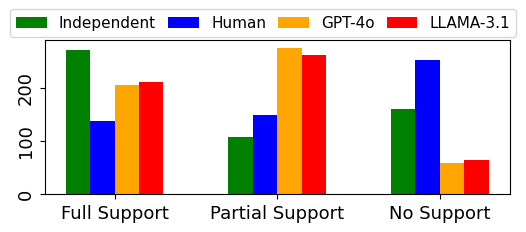

In [2]:
z = {"Human (Expert)": [270, 108, 159],
"Human": [138, 148, 251],
"GPT-4o)": [204, 275, 58],
"LLAMA-3.1": [210, 262, 65]}

# plot the following data as a histogram for the human expert, human, gpt-4o and llama-3.1
import matplotlib.pyplot as plt
import numpy as np

labels = ['Full Support', 'Partial Support', 'No Support']
nandan = z["Human (Expert)"]
nist = z["Human"]
gpt4o = z["GPT-4o)"]
llama = z["LLAMA-3.1"]

x = np.arange(len(labels))
width = 0.15

plt.figure(figsize=(6, 1.8))
rects3 = plt.bar(x - 1.5 * width, nandan, width, label='Independent', color='green')
rects1 = plt.bar(x - 0.5 * width, nist, width, label='Human', color='blue')
rects2 = plt.bar(x + 0.5 *width, gpt4o, width, label='GPT-4o', color='orange')
rects3 = plt.bar(x + 1.5 * width, llama, width, label='LLAMA-3.1', color='red')

plt.ylabel('')
plt.title('')
plt.xticks(x, labels, fontsize=13)
plt.yticks(fontsize=13, rotation=90, va='center')
plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.47, 1.25), fontsize=11, columnspacing=0.8)
# save as pdf
plt.savefig('count_distribution.pdf', format='pdf', bbox_inches='tight')